# **Student Performance Dataset**

### *Preparing the dataset*

In [4]:
# Import all librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from graphviz import Source
from IPython.display import Image, display
import os

In [5]:
# Load the Student Performance dataset from the CSV file
student_data = pd.read_csv('student-por.csv', delimiter=';')

# Feature columns (Input variables)
X = student_data.drop(columns=['G3'])

# Apply One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Output column (Target variable)
y = student_data['G3']


# 2.1: Grouping quality into categories
def categorize_performance(G3):
    if G3 <= 9:
        return 'Low Performance'
    elif G3 <= 14:
        return 'Average Performance'
    else:
        return 'High Performance'

y = y.apply(categorize_performance)

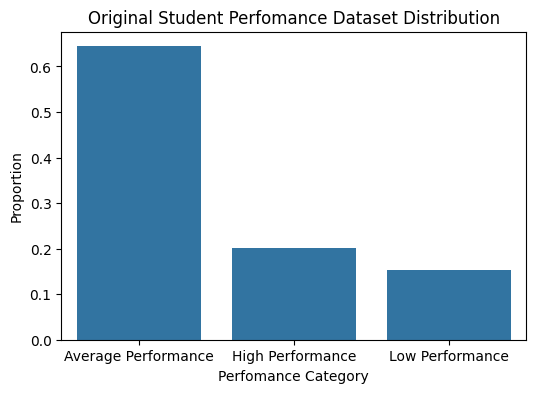

In [6]:
# Visualizing class distribution in the original dataset
original_dist = y.value_counts(normalize=True)
plt.figure(figsize=(6, 4))
sns.barplot(x=original_dist.index, y=original_dist.values)
plt.title("Original Student Perfomance Dataset Distribution")
plt.xlabel("Perfomance Category")
plt.ylabel("Proportion")
plt.show()

In [7]:
def split_and_visualize(X, y, train_size):
    # Perform stratified splitting
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=42
    )

    # Visualize class distribution
    train_dist = label_train.value_counts(normalize=True)
    test_dist = label_test.value_counts(normalize=True)

    print(f"Training set distribution (Train size = {train_size}):")
    print(train_dist)
    print(f"Test set distribution (Train size = {train_size}):")
    print(test_dist)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.barplot(x=train_dist.index, y=train_dist.values, ax=ax[0])
    ax[0].set_title("Training Set Distribution")
    sns.barplot(x=test_dist.index, y=test_dist.values, ax=ax[1])
    ax[1].set_title("Test Set Distribution")
    plt.show()

    return feature_train, feature_test, label_train, label_test


--- Train/Test Split: 40/60 ---
Training set distribution (Train size = 0.4):
G3
Average Performance    0.644788
High Performance       0.200772
Low Performance        0.154440
Name: proportion, dtype: float64
Test set distribution (Train size = 0.4):
G3
Average Performance    0.643590
High Performance       0.202564
Low Performance        0.153846
Name: proportion, dtype: float64


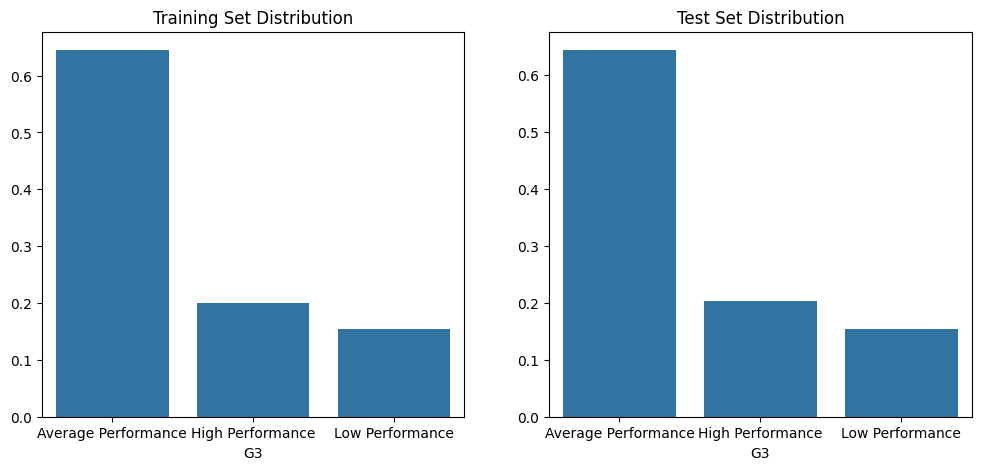


--- Train/Test Split: 60/40 ---
Training set distribution (Train size = 0.6):
G3
Average Performance    0.645244
High Performance       0.200514
Low Performance        0.154242
Name: proportion, dtype: float64
Test set distribution (Train size = 0.6):
G3
Average Performance    0.642308
High Performance       0.203846
Low Performance        0.153846
Name: proportion, dtype: float64


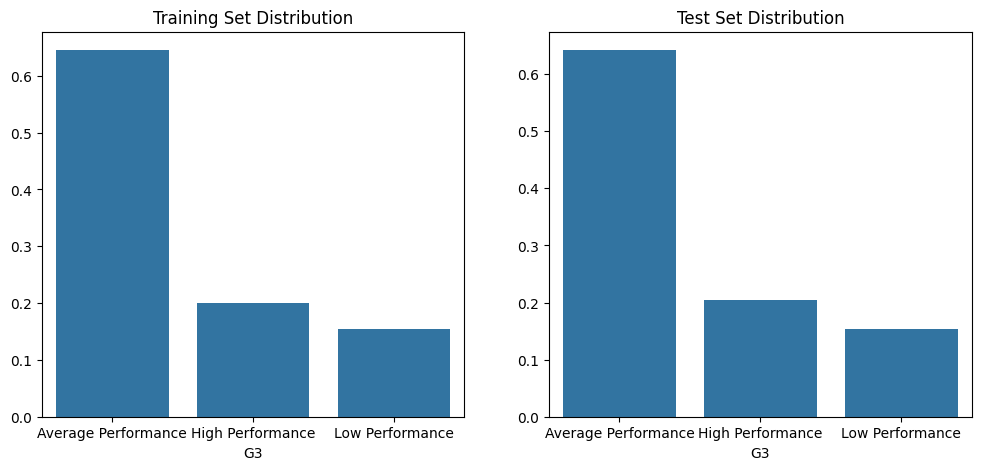


--- Train/Test Split: 80/20 ---
Training set distribution (Train size = 0.8):
G3
Average Performance    0.643545
High Performance       0.202312
Low Performance        0.154143
Name: proportion, dtype: float64
Test set distribution (Train size = 0.8):
G3
Average Performance    0.646154
High Performance       0.200000
Low Performance        0.153846
Name: proportion, dtype: float64


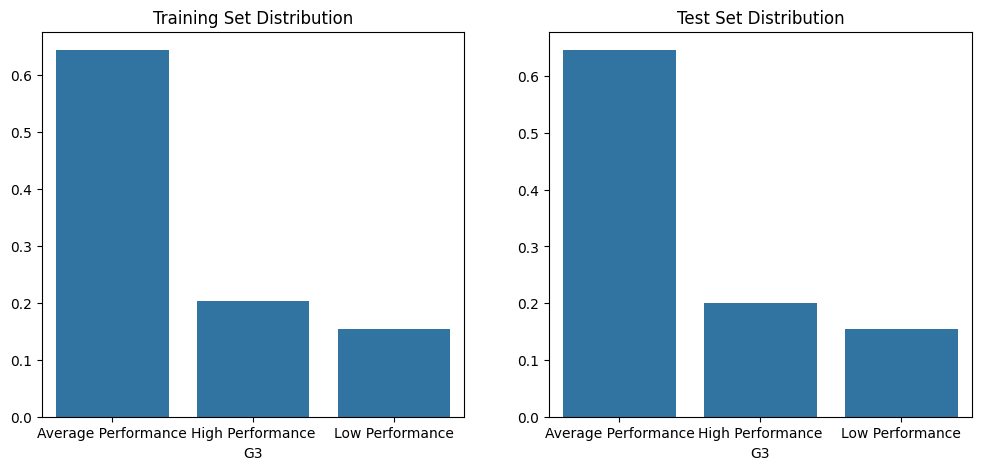


--- Train/Test Split: 90/10 ---
Training set distribution (Train size = 0.9):
G3
Average Performance    0.643836
High Performance       0.202055
Low Performance        0.154110
Name: proportion, dtype: float64
Test set distribution (Train size = 0.9):
G3
Average Performance    0.646154
High Performance       0.200000
Low Performance        0.153846
Name: proportion, dtype: float64


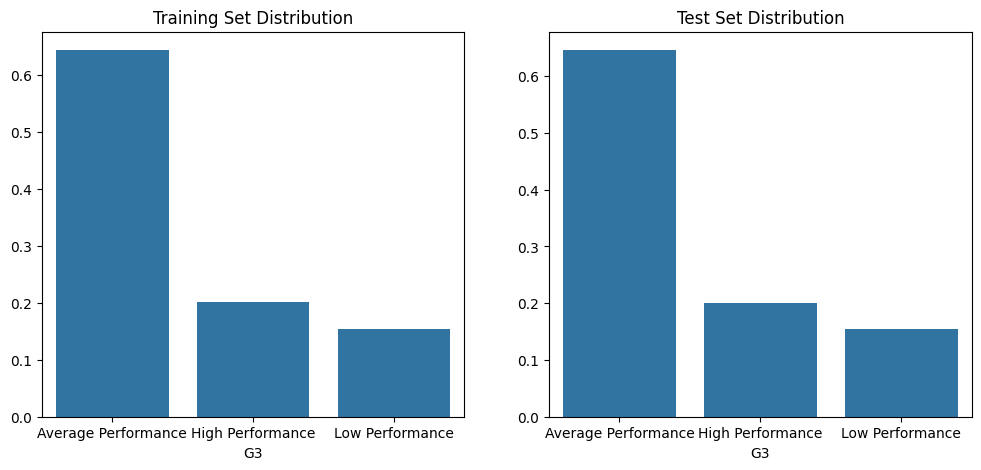

In [8]:
splits = [0.4, 0.6, 0.8, 0.9]

# Store the subsets
datasets = []

# Store the subsets
for split in splits:
    print(f"\n--- Train/Test Split: {int(round(split*100))}/{int(round((1-split)*100))} ---")
    feature_train, feature_test, label_train, label_test = split_and_visualize(X_encoded, y, split)
    datasets.append({
        "train_size": split,
        "feature_train": feature_train,
        "label_train": label_train,
        "feature_test": feature_test,
        "label_test": label_test
    })

### *Building the decision tree classifier*

In [9]:
# Define the folder where images will be saved
output_folder = "SP_dataset_decision_trees"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

In [10]:
def train_and_visualize_decision_tree(feature_train, label_train, train_size, output_folder) -> tuple:
    # Ensure the label is a pandas Series
    if isinstance(label_train, pd.DataFrame):
        label_train = label_train.squeeze()

    # Initialize the classifier
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(feature_train, label_train)

    # Get the depth of the trained tree
    tree_depth = clf.get_depth()

    # Export the decision tree as DOT data
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_train.columns,
        class_names=label_train.astype(str).unique(),
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Render and save the tree visualization
    image_path = os.path.join(output_folder, f"DecisionTree_{int(train_size * 100)}")
    graph = Source(dot_data)
    graph.render(image_path, format='png', cleanup=True)

    # Display the decision tree image in the notebook
    display(Image(filename=image_path + ".png", width=1300))

    return clf, tree_depth


--- Training Decision Tree (Train size = 0.4) ---


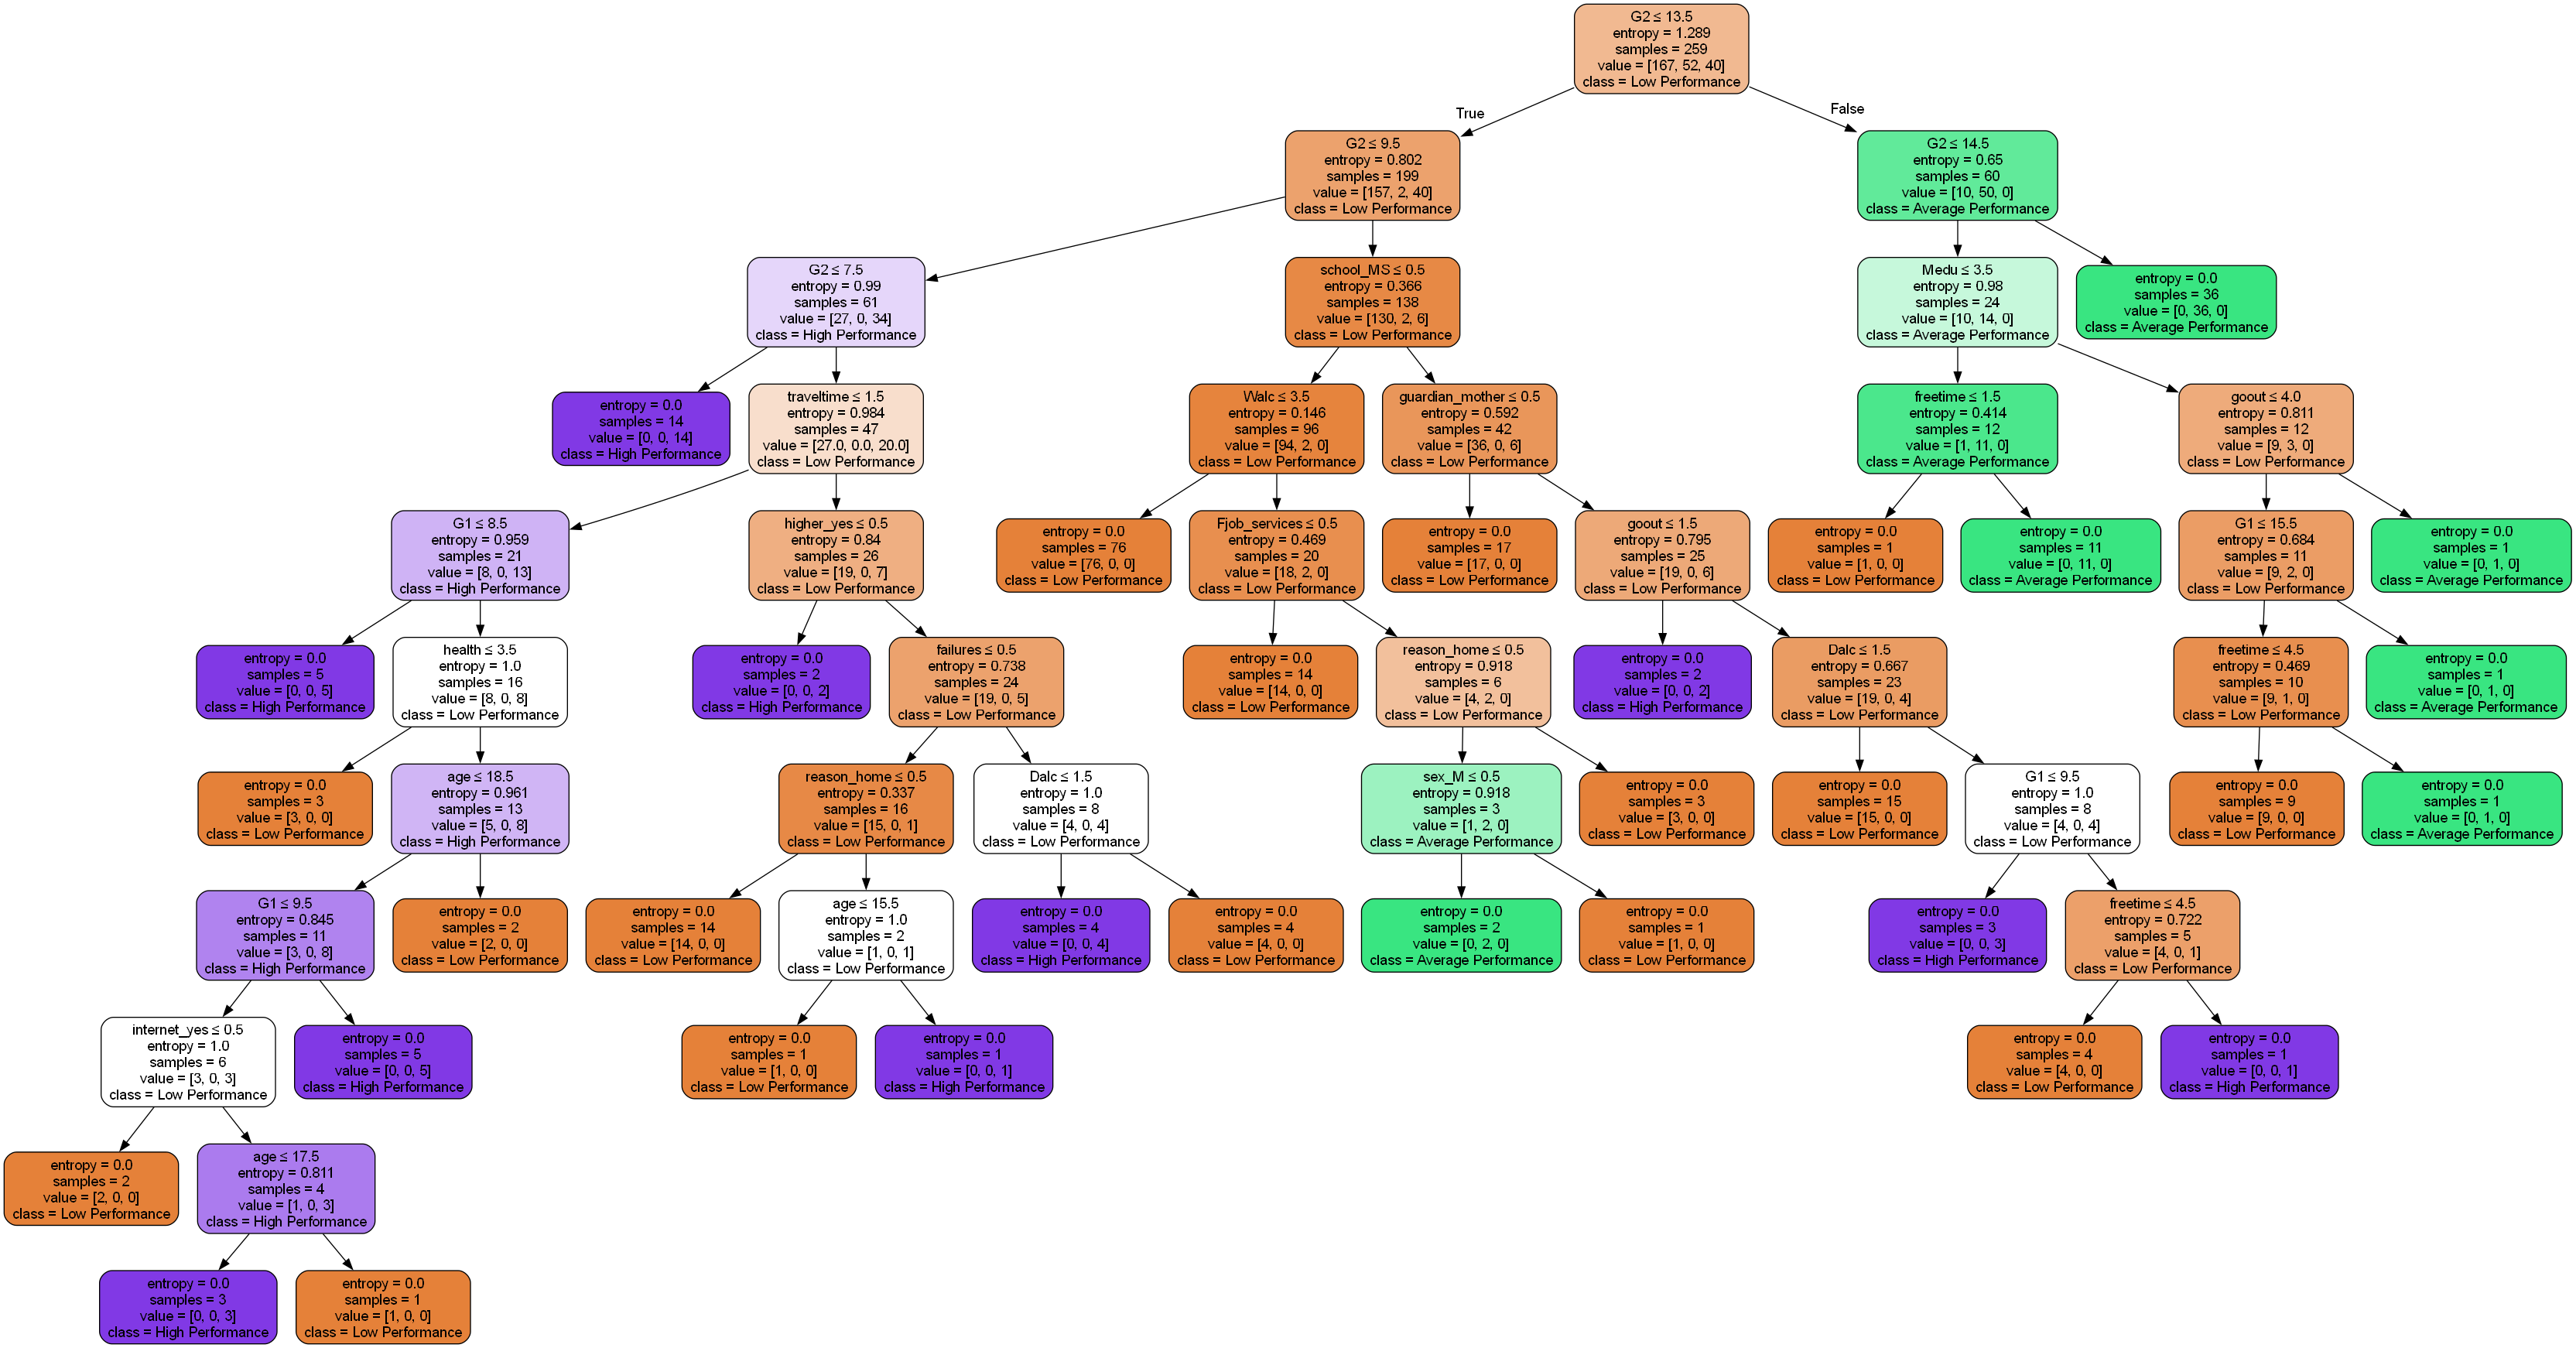

Decision Tree Depth: 10

--- Training Decision Tree (Train size = 0.6) ---


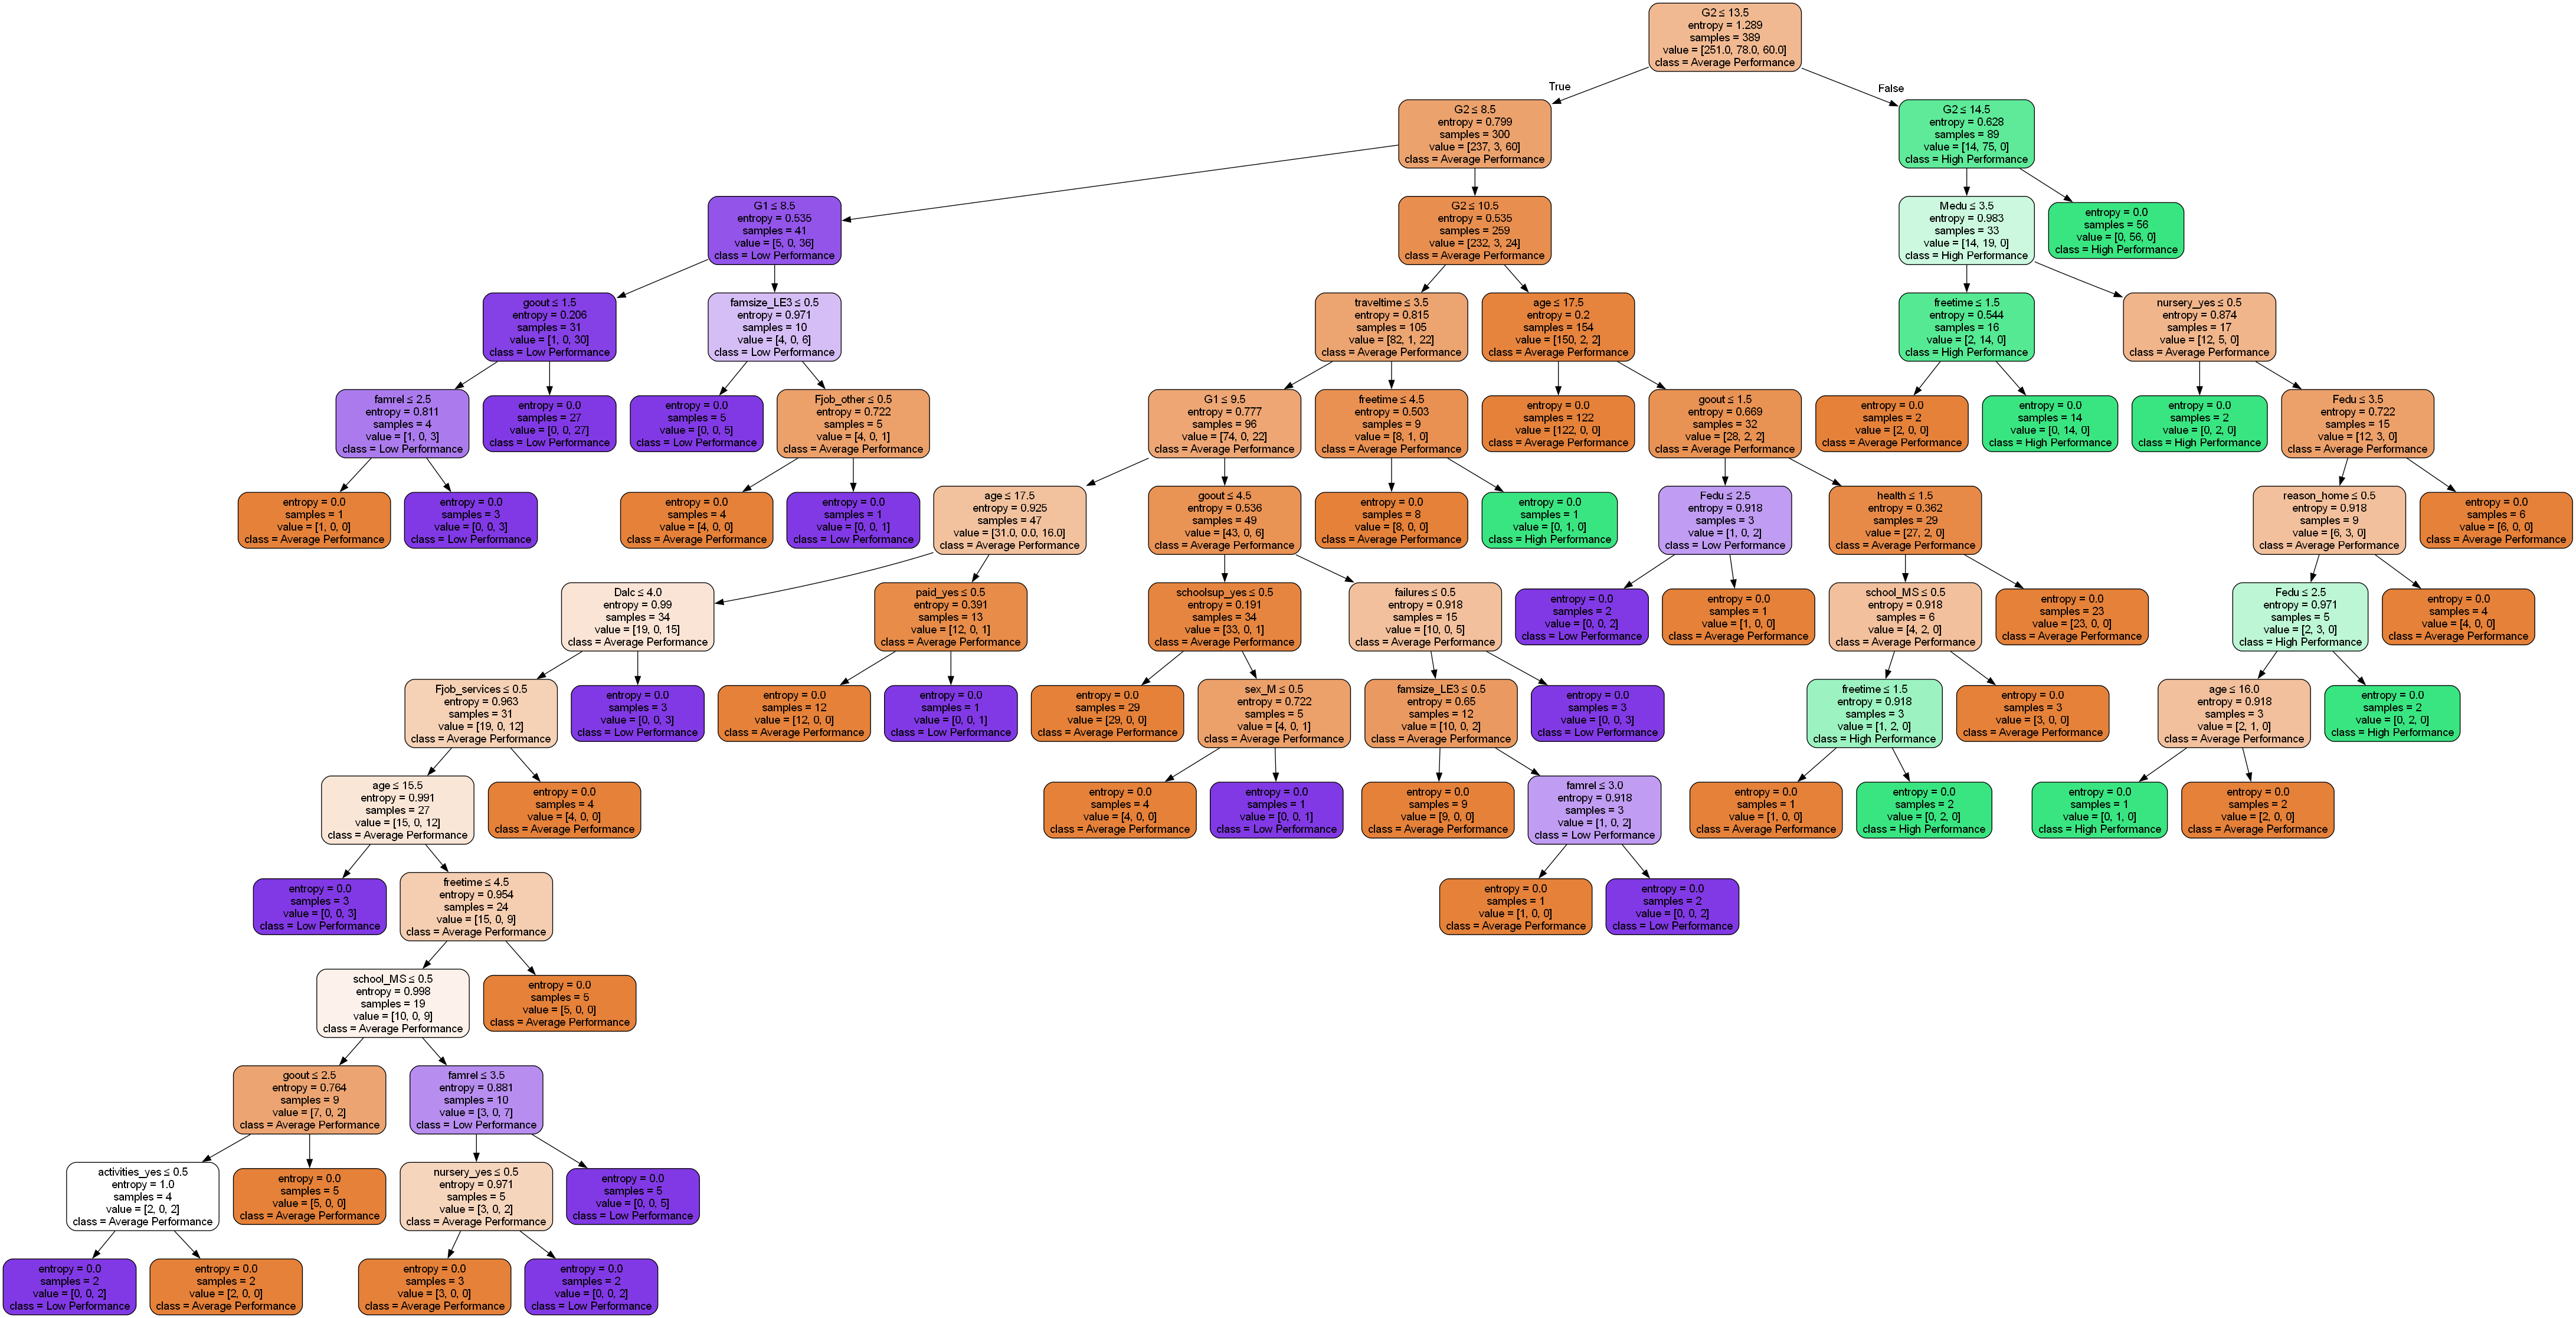

Decision Tree Depth: 13

--- Training Decision Tree (Train size = 0.8) ---


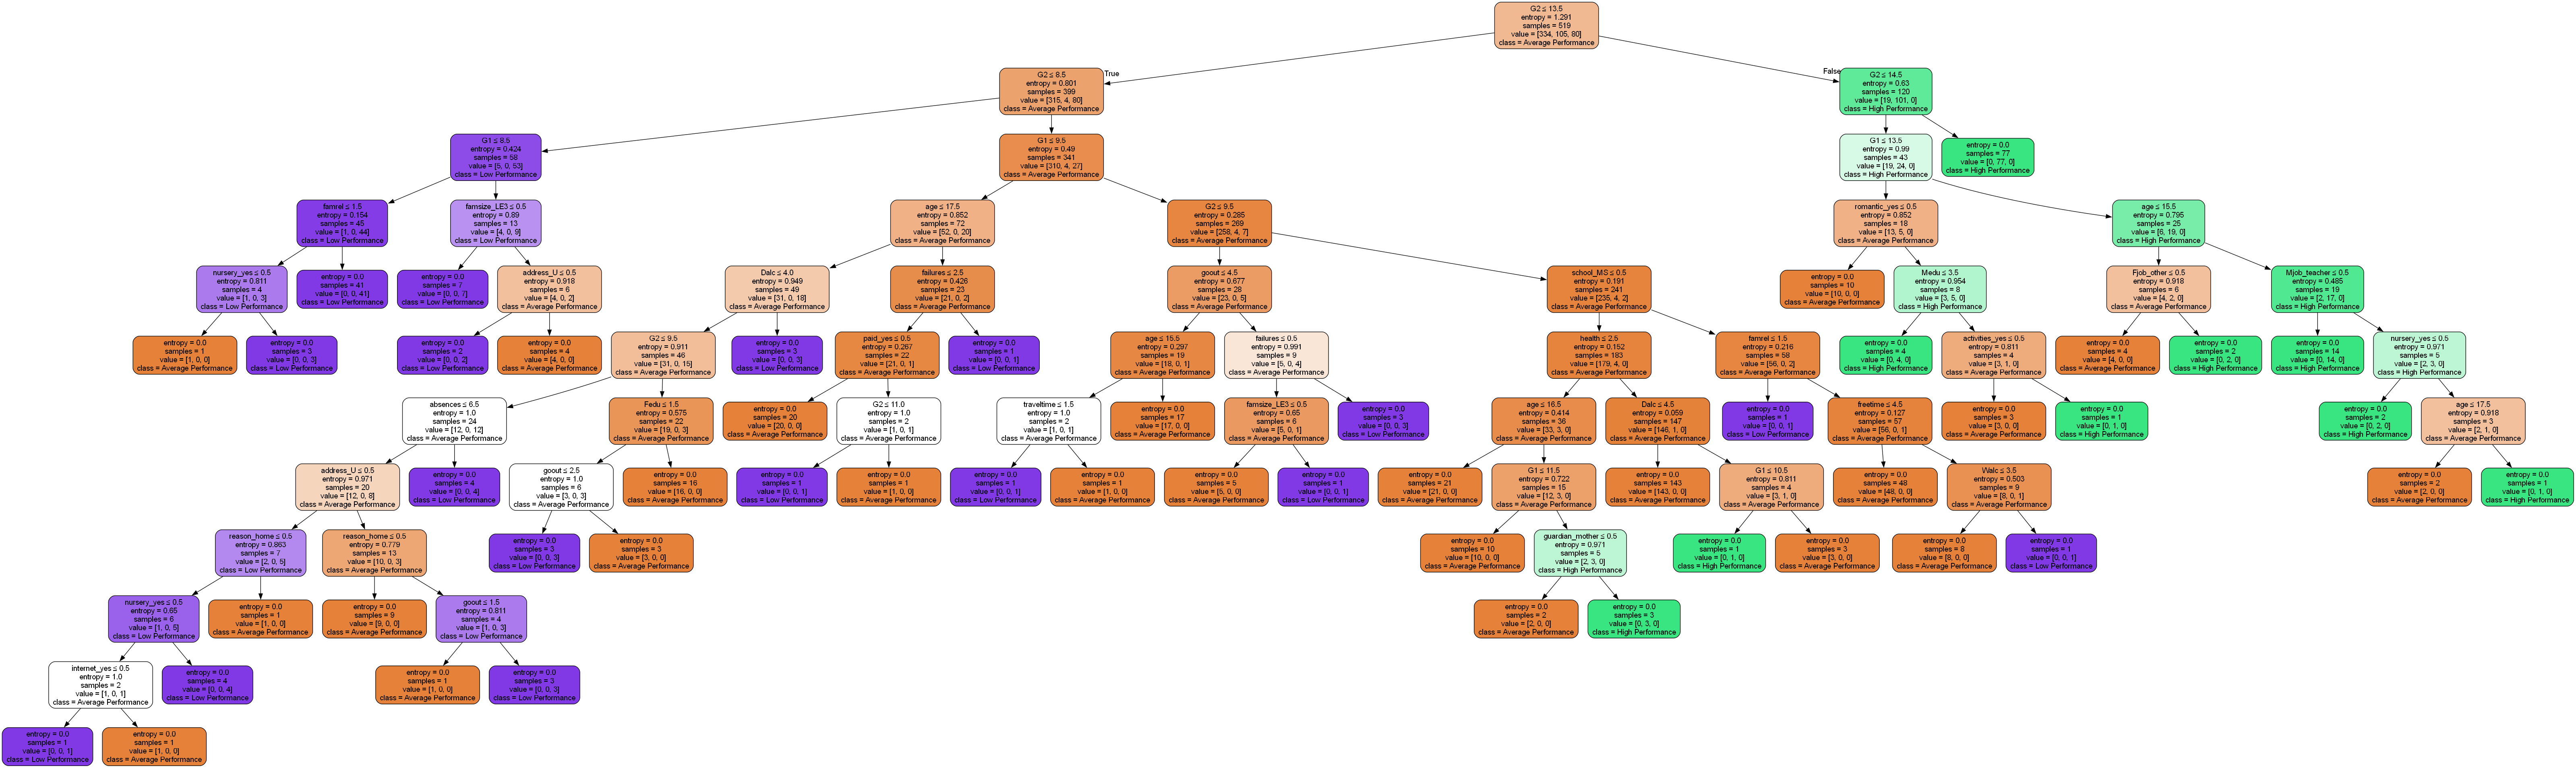

Decision Tree Depth: 11

--- Training Decision Tree (Train size = 0.9) ---


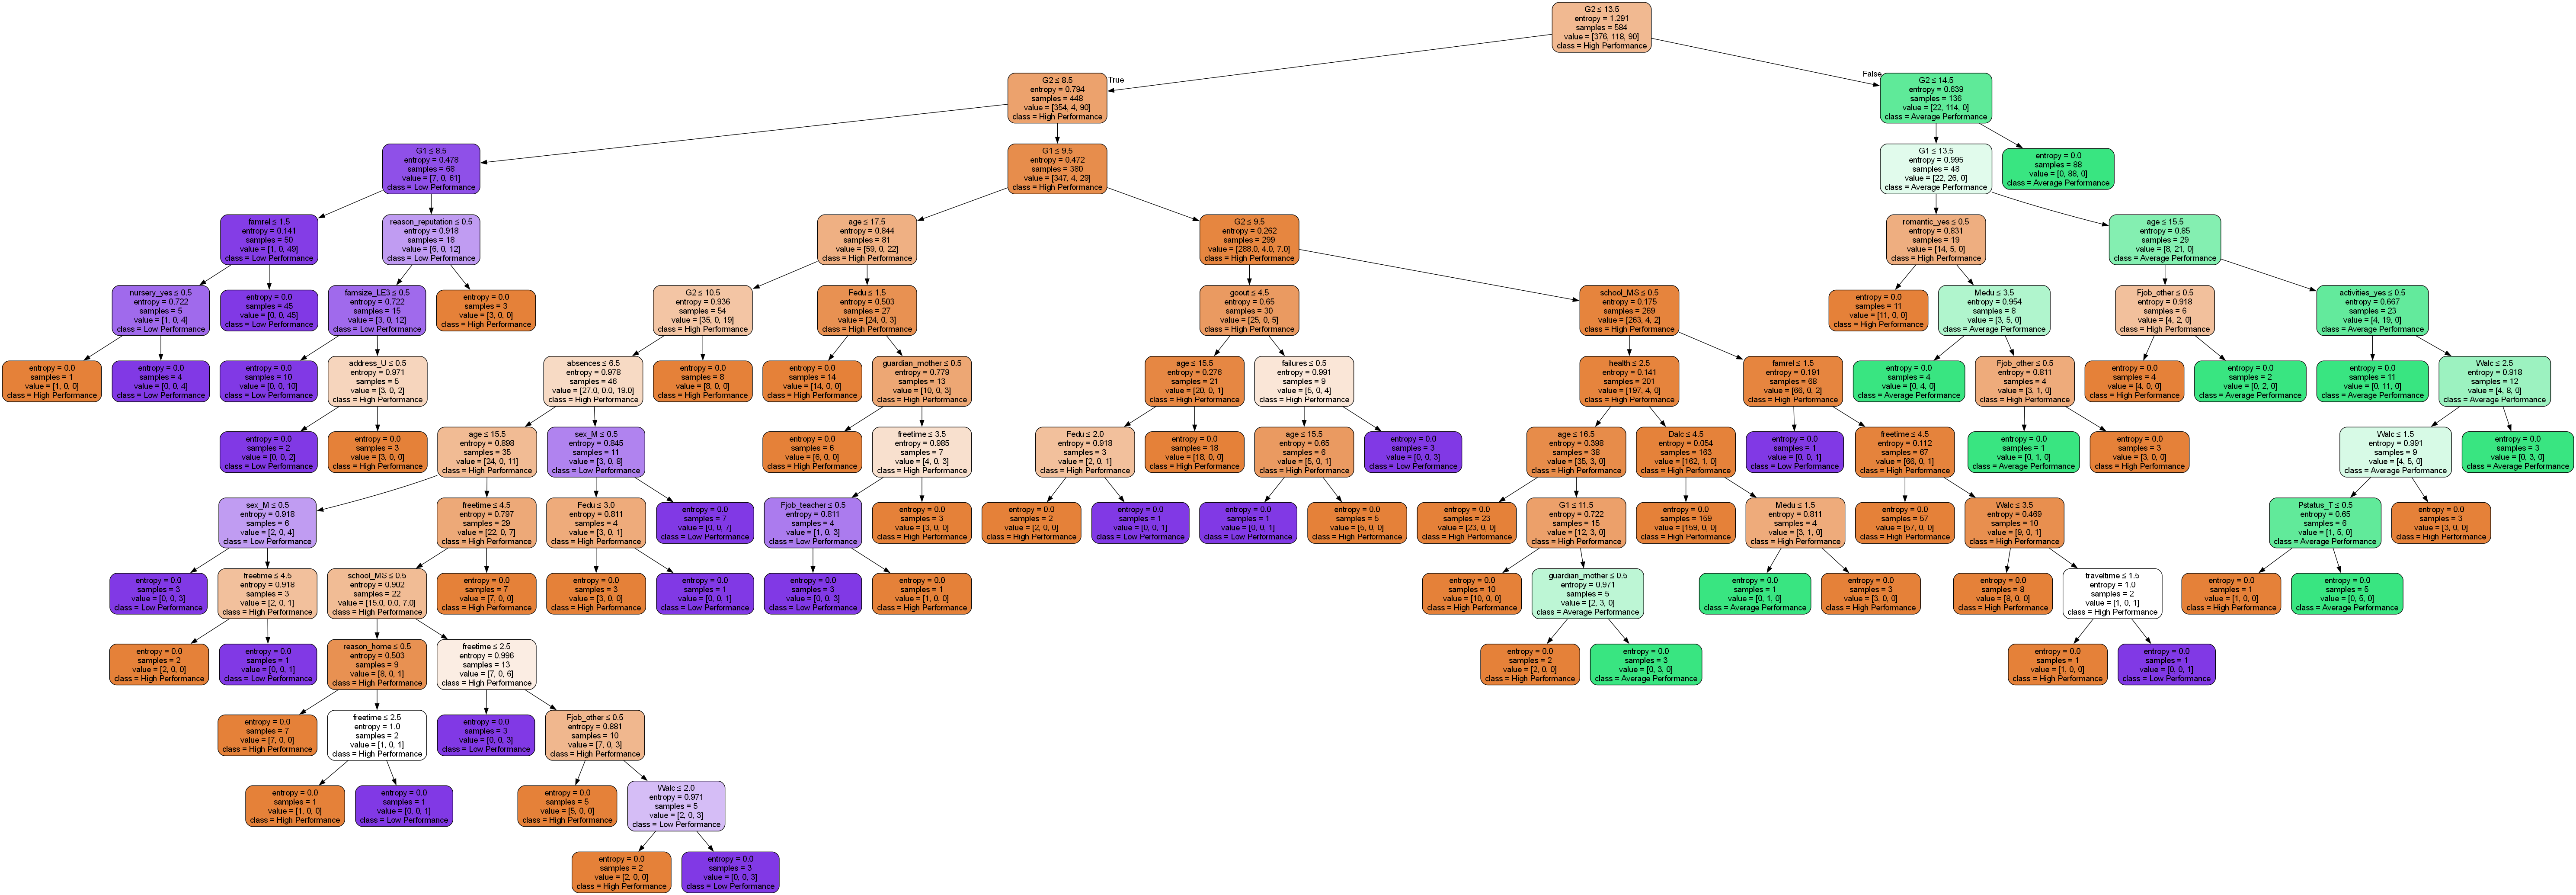

Decision Tree Depth: 12


In [11]:
# Initialize an empty dictionary to store trained classifiers
trained_classifiers = {}

# Train and visualize decision trees for each split
for dataset in datasets:
    print(f"\n--- Training Decision Tree (Train size = {dataset['train_size']}) ---")
    
    # Train and get depth
    clf, tree_depth = train_and_visualize_decision_tree(
        dataset['feature_train'],
        dataset['label_train'],
        dataset['train_size'],
        output_folder
    )

    # Print the depth after training
    print(f"Decision Tree Depth: {tree_depth}")
    
    # Store the trained classifier
    train_size_str = str(dataset['train_size'])  # Use train size as key
    trained_classifiers[train_size_str] = clf

### *Evaluating the decision tree classifier*

In [12]:
def evaluate_decision_tree(clf, feature_test, label_test, train_size):
    # Make predictions on the test set
    predictions = clf.predict(feature_test)
    
    # Generate the classification report
    report = classification_report(label_test, predictions)
    print(f"Classification Report for Train Size = {train_size}:\n")
    print(report)
    
    # Generate the confusion matrix
    cm = confusion_matrix(label_test, predictions)
    
    # Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_test.unique(), yticklabels=label_test.unique())
    plt.title(f"Confusion Matrix (Train Size = {train_size})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    plt.close()


--- Evaluating Decision Tree (Train size = 0.4) ---
Classification Report for Train Size = 0.4:

                     precision    recall  f1-score   support

Average Performance       0.90      0.84      0.87       251
   High Performance       0.80      0.89      0.84        79
    Low Performance       0.68      0.77      0.72        60

           accuracy                           0.84       390
          macro avg       0.79      0.83      0.81       390
       weighted avg       0.85      0.84      0.84       390



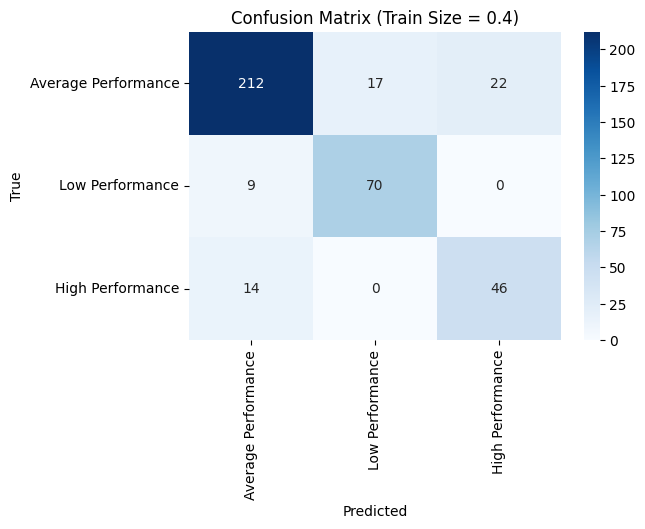


--- Evaluating Decision Tree (Train size = 0.6) ---
Classification Report for Train Size = 0.6:

                     precision    recall  f1-score   support

Average Performance       0.89      0.85      0.87       167
   High Performance       0.80      0.89      0.84        53
    Low Performance       0.67      0.70      0.68        40

           accuracy                           0.83       260
          macro avg       0.79      0.81      0.80       260
       weighted avg       0.84      0.83      0.84       260



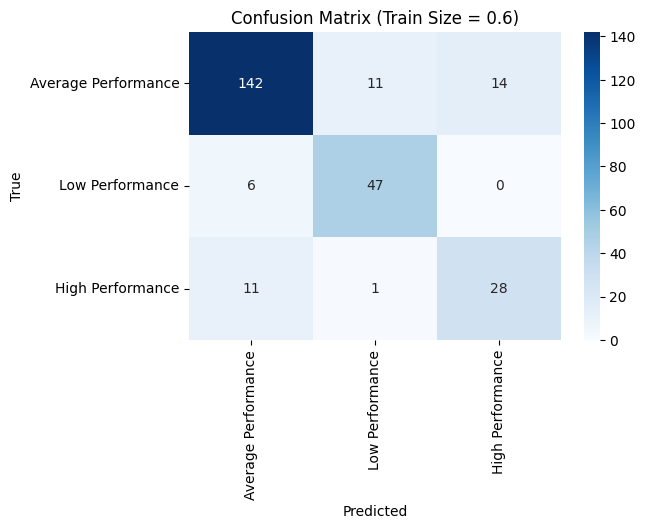


--- Evaluating Decision Tree (Train size = 0.8) ---
Classification Report for Train Size = 0.8:

                     precision    recall  f1-score   support

Average Performance       0.93      0.83      0.88        84
   High Performance       0.77      0.92      0.84        26
    Low Performance       0.71      0.85      0.77        20

           accuracy                           0.85       130
          macro avg       0.81      0.87      0.83       130
       weighted avg       0.87      0.85      0.86       130



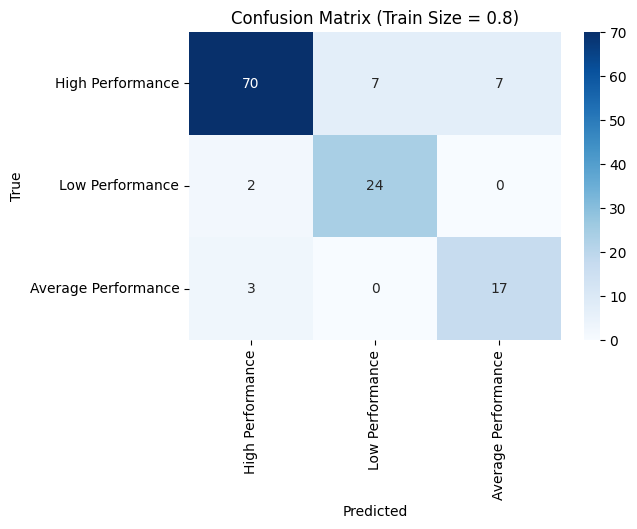


--- Evaluating Decision Tree (Train size = 0.9) ---
Classification Report for Train Size = 0.9:

                     precision    recall  f1-score   support

Average Performance       0.88      0.88      0.88        42
   High Performance       0.71      0.92      0.80        13
    Low Performance       1.00      0.60      0.75        10

           accuracy                           0.85        65
          macro avg       0.86      0.80      0.81        65
       weighted avg       0.86      0.85      0.84        65



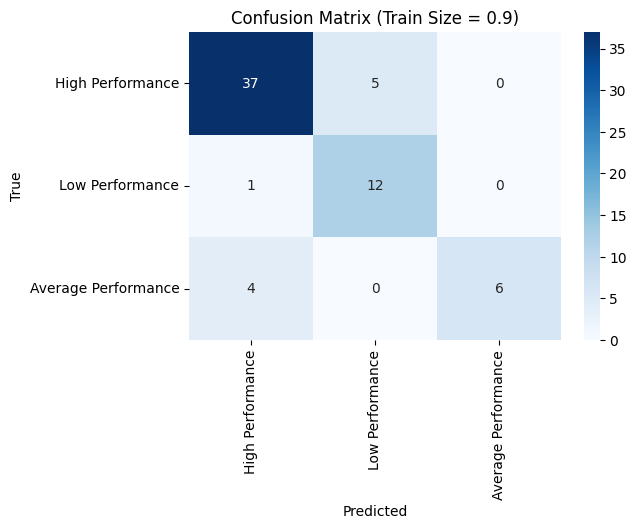

In [13]:
# Evaluate decision trees for each dataset split
for dataset in datasets:
    train_size_str = f"{dataset['train_size']}"  # Retrieve the key for the classifier
    clf = trained_classifiers[train_size_str]  # Retrieve the trained classifier
    
    # Evaluate the trained classifier on the test set
    print(f"\n--- Evaluating Decision Tree (Train size = {dataset['train_size']}) ---")
    evaluate_decision_tree(clf, dataset['feature_test'], dataset['label_test'], dataset['train_size'])

### *The depth and accuracy of a decision tree*

In [14]:
# Folder to save decision tree images for different depths
output_folder = "SP_dataset_decision_trees/max_depth_trees"
os.makedirs(output_folder, exist_ok=True)

In [15]:
# Values for max_depth
depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []

Decision Tree (max_depth=None):


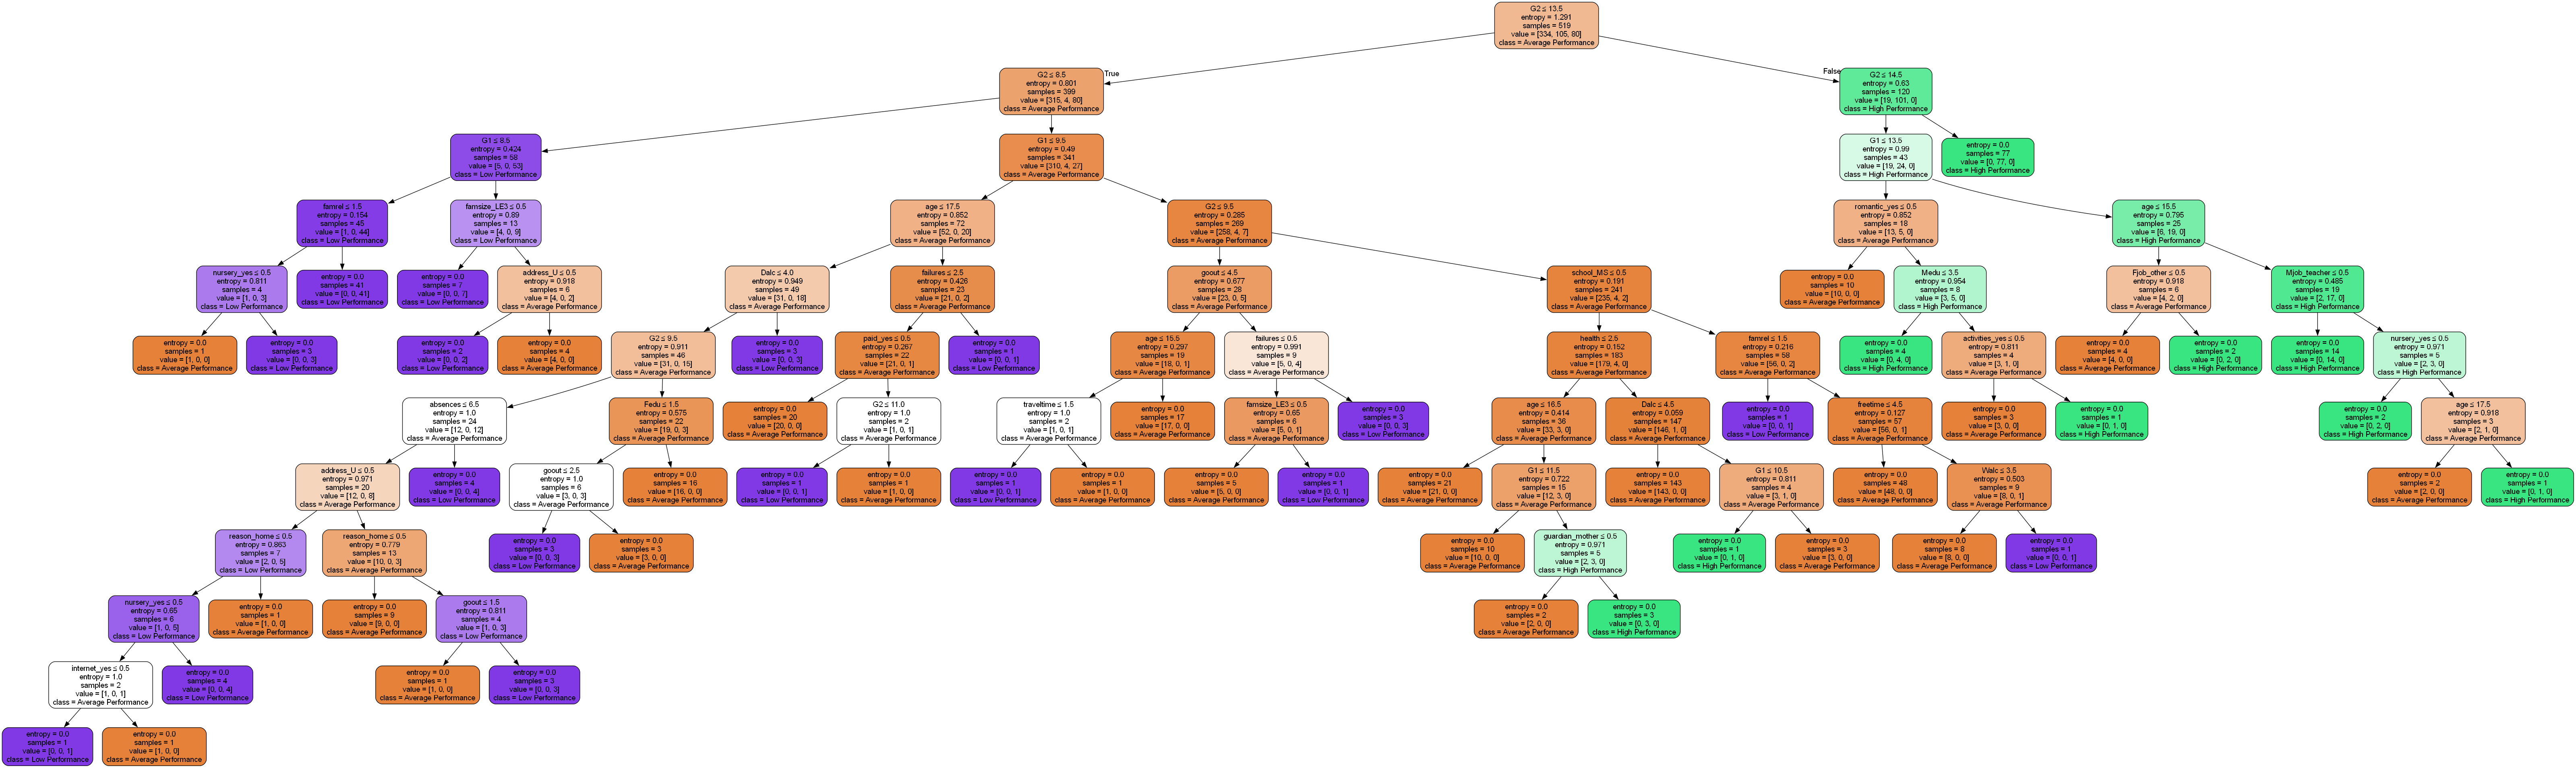

Decision Tree (max_depth=2):


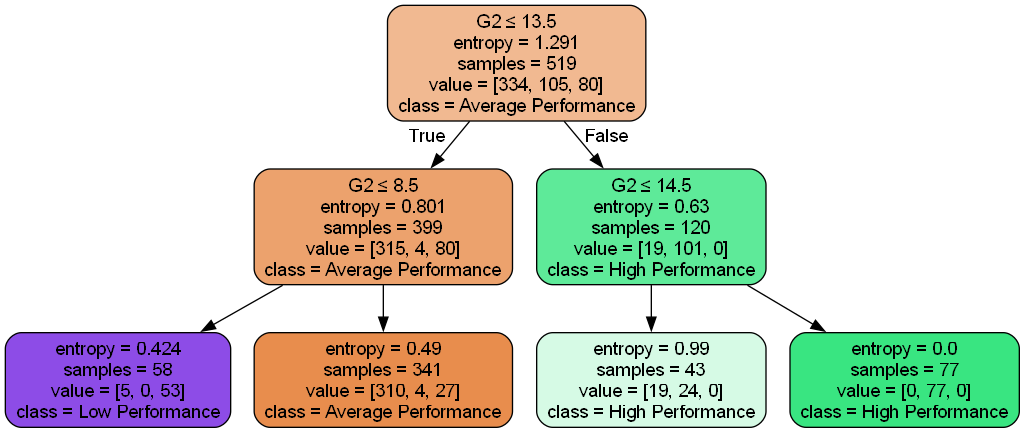

Decision Tree (max_depth=3):


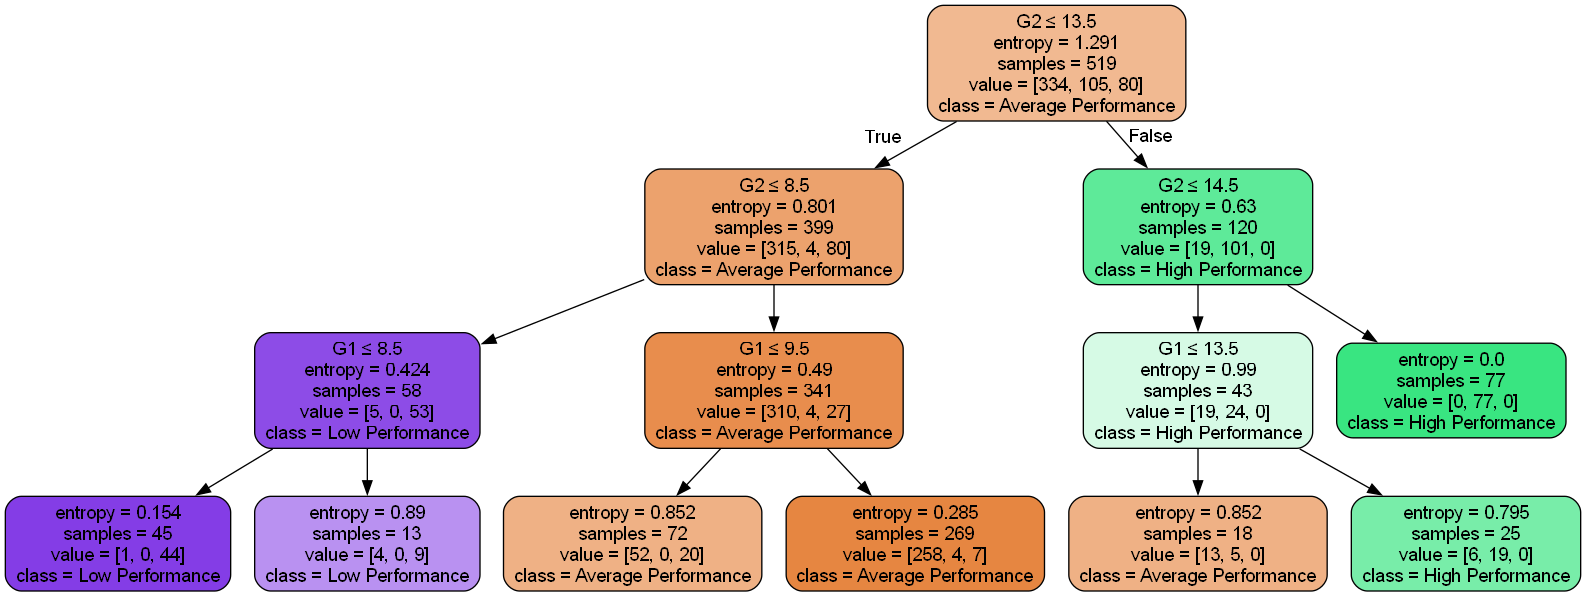

Decision Tree (max_depth=4):


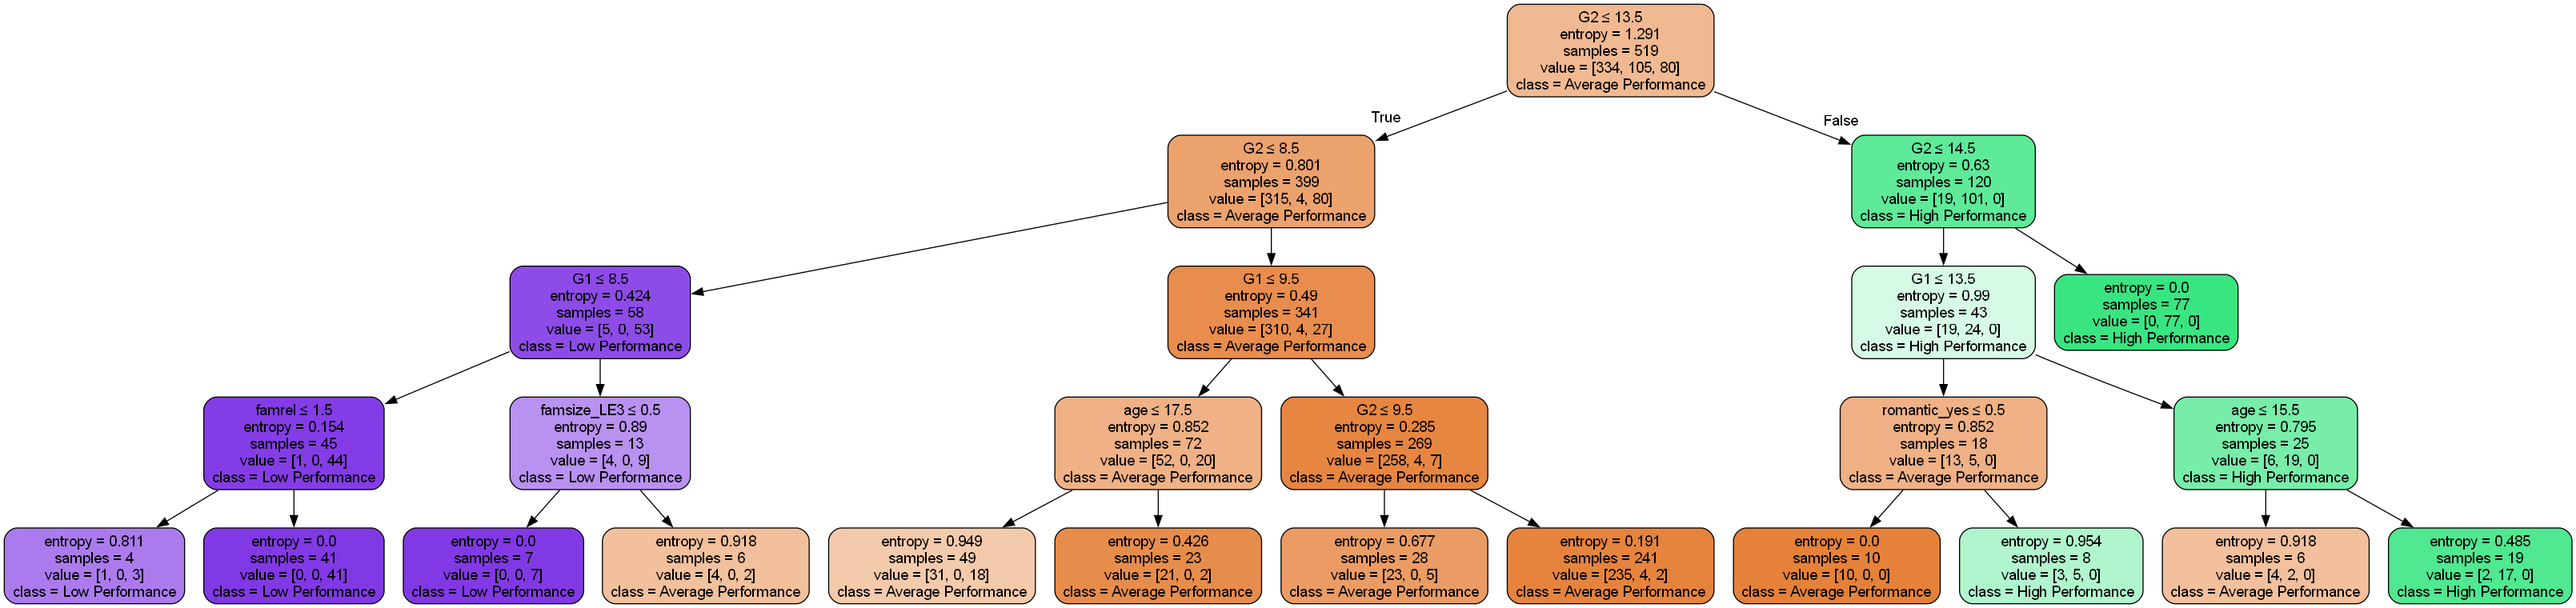

Decision Tree (max_depth=5):


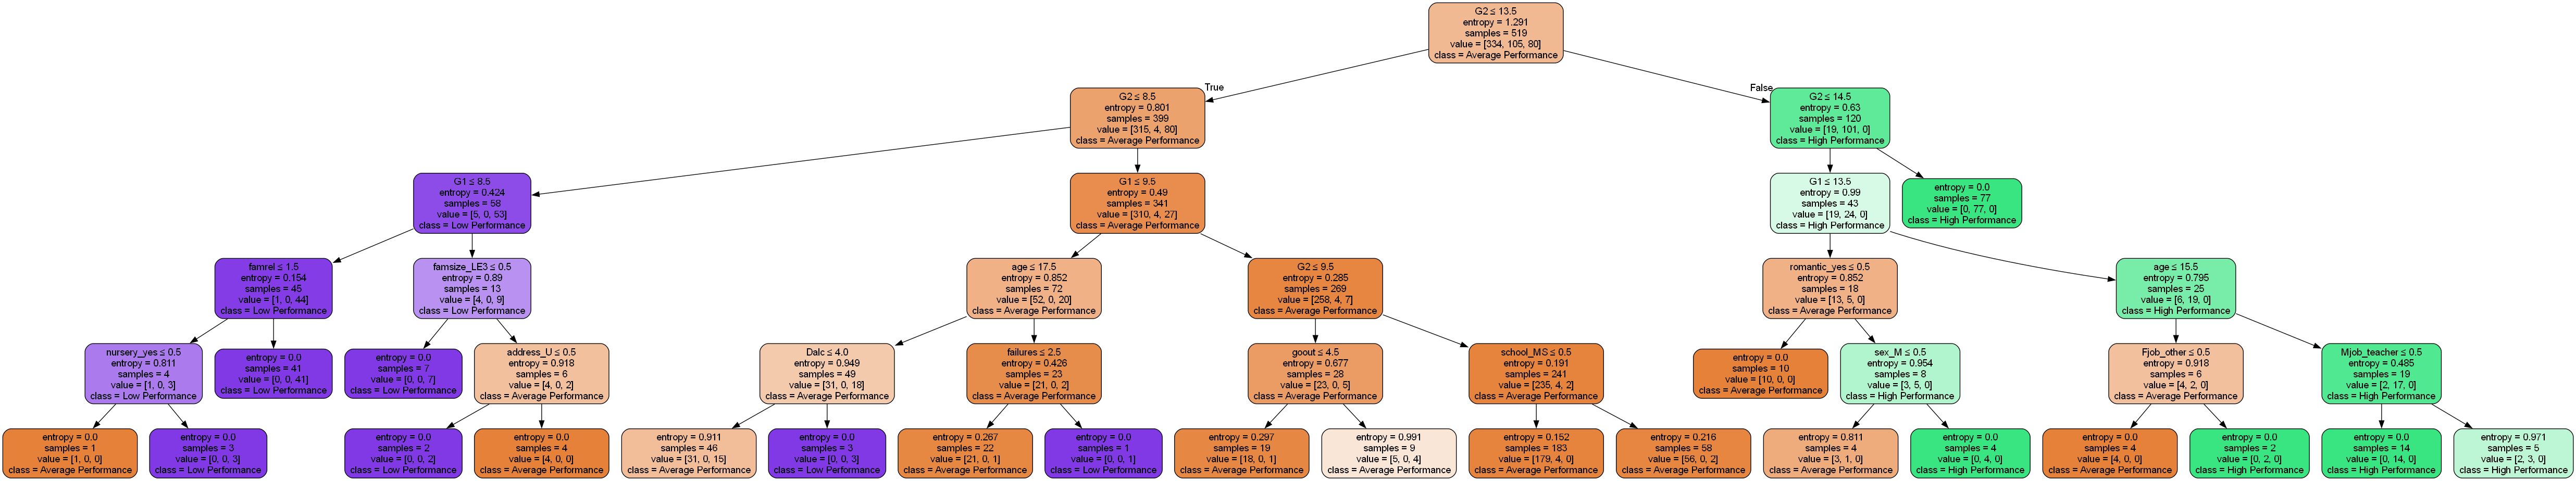

Decision Tree (max_depth=6):


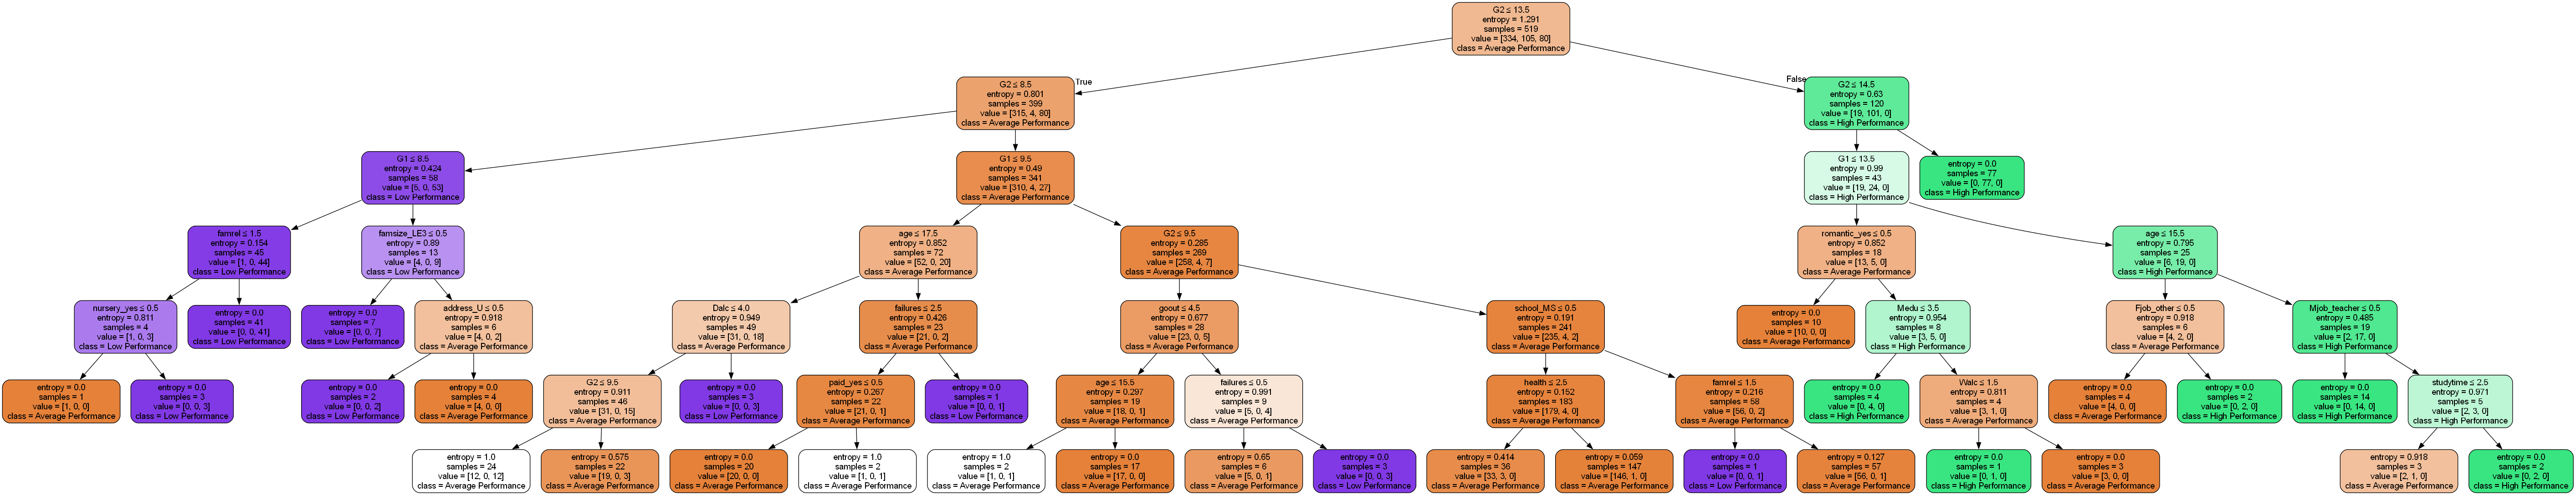

Decision Tree (max_depth=7):


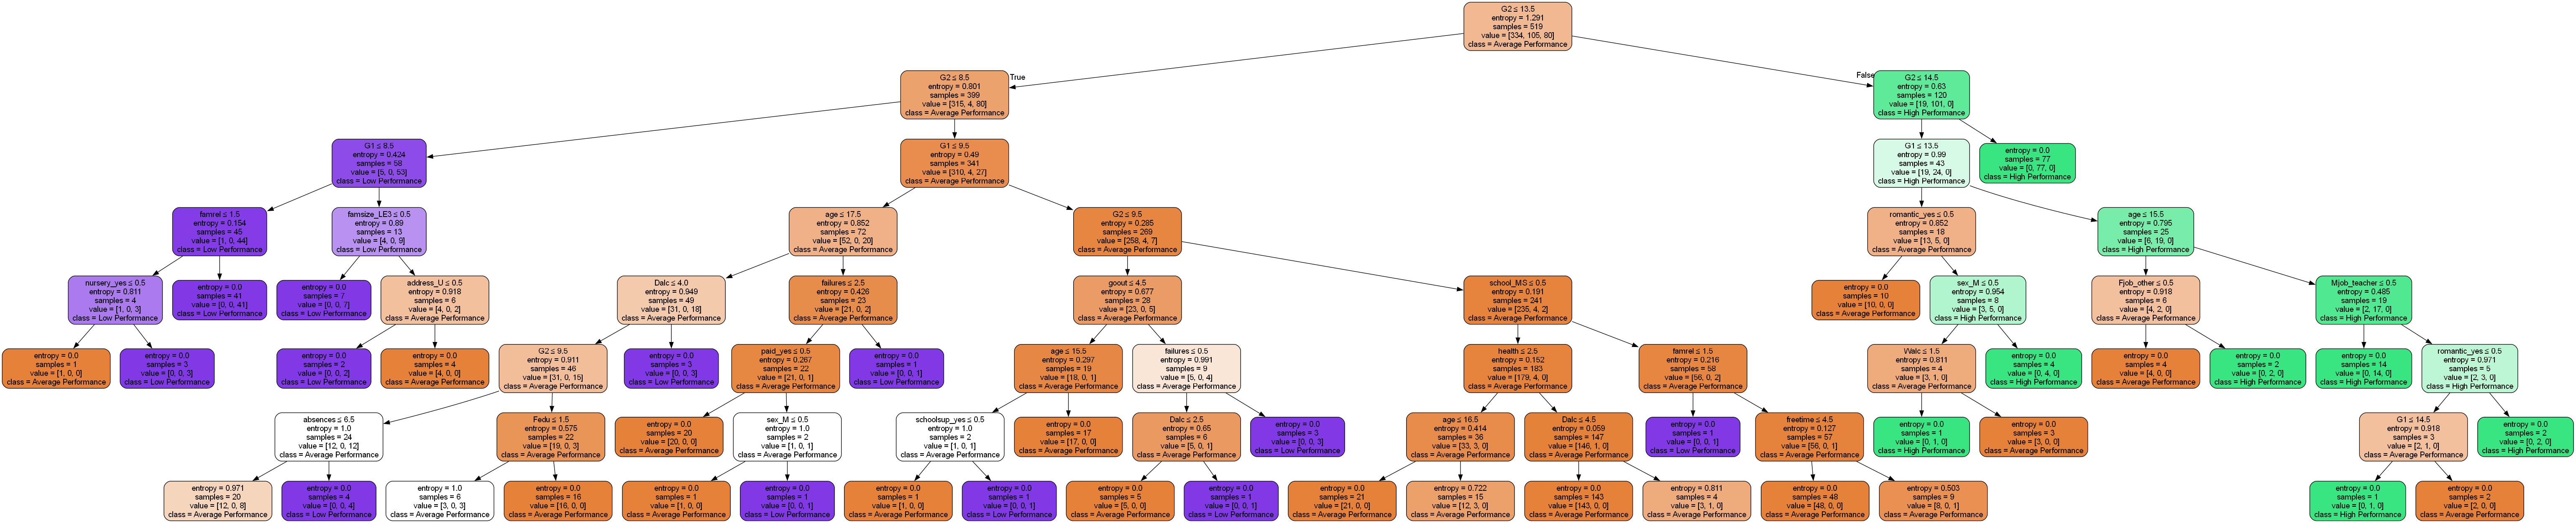

In [16]:
# Train and evaluate decision trees for different depths
dataset = None
for d in datasets:
    if d['train_size'] == 0.8:
        dataset = d
        break

# Ensure that we found the dataset with 80/20 split
if dataset is None:
    raise ValueError("No dataset found with 80/20 train-test split.")

for max_depth in depth_values:
    # Train the decision tree
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=max_depth)
    clf.fit(dataset['feature_train'], dataset['label_train'])  # Train using current dataset

    # Predict and calculate accuracy
    predictions = clf.predict(dataset['feature_test'])
    accuracy = accuracy_score(dataset['label_test'], predictions)
    accuracy_results.append(accuracy)
    
    # Visualize the decision tree
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=dataset['feature_train'].columns,
        class_names=dataset['label_train'].unique().astype(str),
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = Source(dot_data)
    image_path = os.path.join(output_folder, f"DecisionTree_maxDepth_{max_depth}")
    graph.render(image_path, format='png', cleanup=True)

    # Display the tree in the notebook
    print(f"Decision Tree (max_depth={max_depth}):")
    display(Image(filename=image_path + ".png", width=1300))

In [17]:
# Create a table of accuracies for each max_depth value
accuracy_table = pd.DataFrame({
    "max_depth": ["None" if d is None else d for d in depth_values],
    "Accuracy": accuracy_results
})
display(accuracy_table)

max_depth  Accuracy
0      None  0.853846
1         2  0.884615
2         3  0.892308
3         4  0.892308
4         5  0.892308
5         6  0.884615
6         7  0.907692

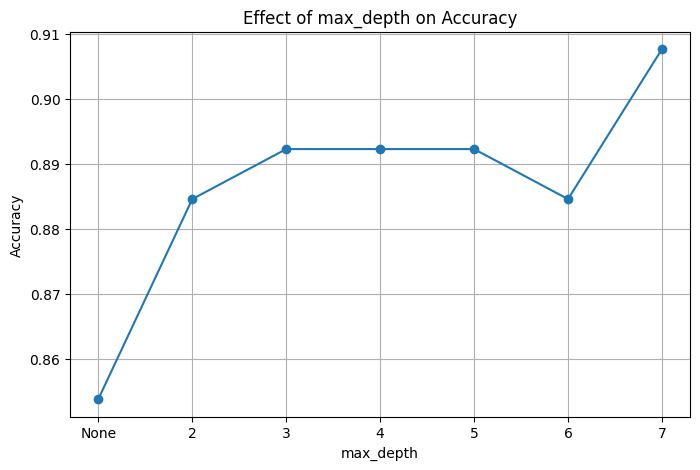

In [18]:
# Plot accuracy scores for different max_depth values
plt.figure(figsize=(8, 5))
plt.plot(["None" if d is None else d for d in depth_values], accuracy_results, marker="o")
plt.title("Effect of max_depth on Accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()